Copy-pasting the stuff from general.ipynb to do an appropriate analysis for the US_multi and NGDC model train-test splits

Just look at the precision recall curve and roc curve for the new models

In [1]:
%matplotlib inline
import os
import numpy as np
import pickle as pkl
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from inspect import signature

In [2]:
def get_performance(true, scores, weights):
    # loss
    loss = np.mean(true * -np.log(scores) + (1 - true) * -np.log(1.0 - scores))
    # auprc
    precision, recall, thr = precision_recall_curve(true, scores, pos_label=1)
    auprc = auc(recall, precision)
    # auroc
    fpr, tpr, _ = roc_curve(true, scores, pos_label=1)
    auroc = auc(fpr, tpr)
    # accuracy
    acc = np.sum(true == (scores > 0.5)) / true.shape[0]
    return (loss, acc, (precision, recall, thr, auprc), (fpr, tpr, auroc))

In [10]:
def plot_prc(ax,prec,rec,thresh,source,auprc):
    ax.plot(rec,prec)
    ax.grid()
    
    scatter_x, scatter_y = [], []
    last_recall = 1.0
    for x, y, thr in zip(recall, precision, thresh):
        if last_recall - x >= 0.1 or last_recall - x >= 0.05 and x >= 0.9:
            ax.annotate(">{:.2f}".format(thr),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')
            scatter_x.append(x)
            scatter_y.append(y)
            last_recall = x
    
    ax.scatter(scatter_x, scatter_y)
    ax.set_title("{} AUPRC={:.4f}".format(source, auprc));
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return

def plot_roc(ax,fpr,tpr,source,auroc):
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.grid()
    ax.set_title("{} AUROC={:.4f}".format(source, auroc));
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    return

In [4]:
sources = ['NGDC', 'US_multi']
scores_dir = "/swot2/features/tsv_all/runtime_scores/"
scores_filename = "model_{}_test_{}_scores.pkl"

## Precision Recall Curve

A description yanked off the sklearn website: Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

So a 1.0 precision means that the classifier will have no false negatives (it will label all bad pings as bad). However, if this is the case, then not all good points will be recalled by the classifier (some good will be called bad). Hence this trade-off curve. As the threshold of precision decreases, we improve our ability to recover all the good pings.

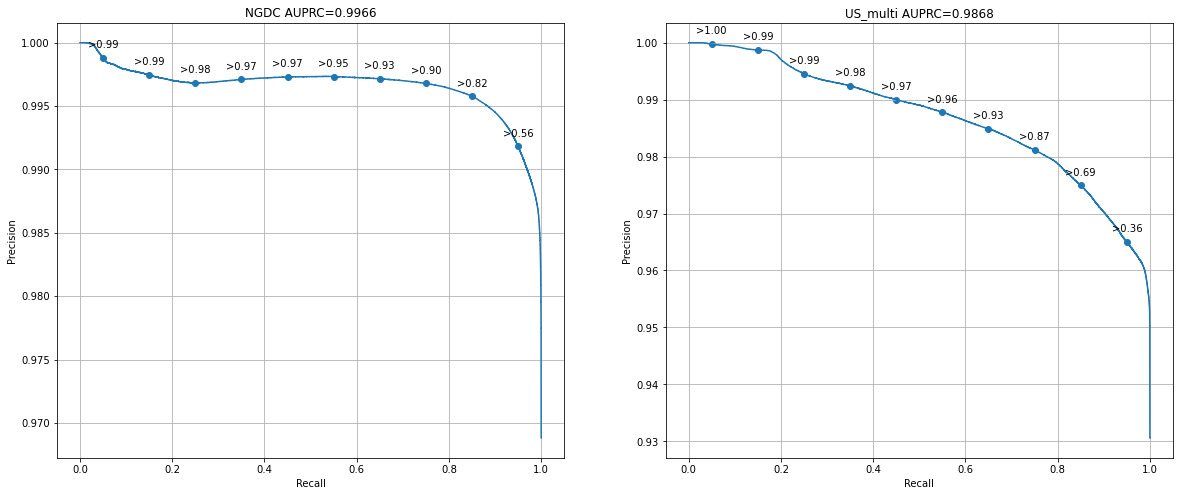

In [11]:
fig, ax_list = plt.subplots(1, 2, figsize=(20,8))

for i, source in enumerate(sources):
    score_file = scores_dir + scores_filename.format(source,source)
    with open(score_file,"rb") as f:
        (features, label, scores, weights) = pkl.load(f)
        
    (loss, acc, (precision, recall, thresh, auprc), _) = get_performance(label,scores,weights)
    axis = ax_list[i]
    plot_prc(axis,precision,recall,thresh,source,auprc)

## Receiver Operating Characteristic
From wikipedia: "a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate."

This is similar to the pr curve. As the true positive rate increases (we're recovering more and more of the good pings), the false positive rate will increase, too (we'll call some bad pings "good").

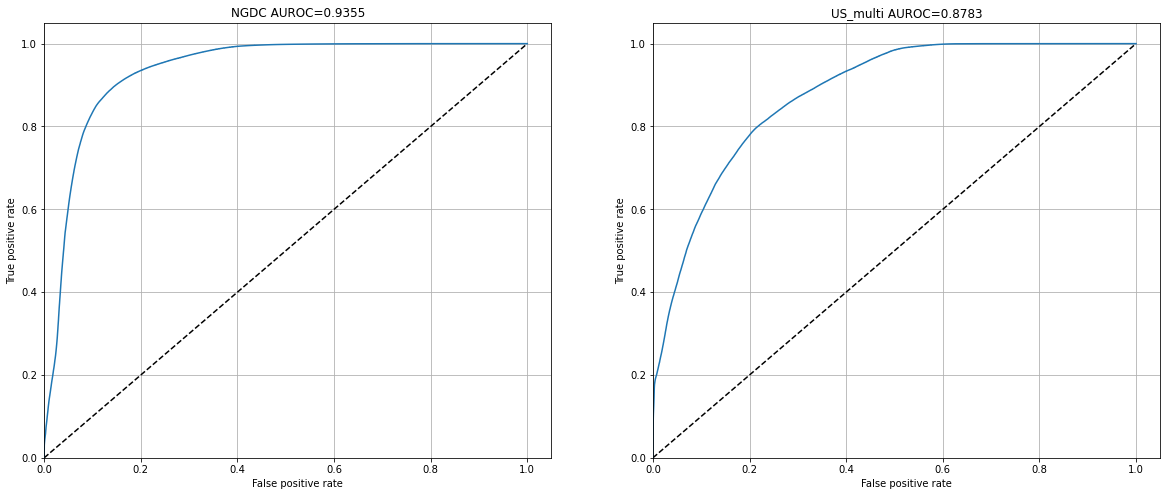

In [53]:
fig, ax_list = plt.subplots(1, 2, figsize=(20,8))

for i, source in enumerate(sources):
    score_file = scores_dir + scores_filename.format(source,source)
    with open(score_file,"rb") as f:
        (features, label, scores, weights) = pkl.load(f)
        
    (_, acc, _, (fpr, tpr, auroc)) = get_performance(label,scores,weights)
    axis = ax_list[i]
    plot_roc(axis,fpr,tpr,source,auroc)